# Notebook 2 - Isotropic Model

- This notebook demonstrates the bayesian statistical analysis preformed Antikythera Calender the using the Isotropic model $(\sigma = \sigma_r = \sigma_t)$
- Notebook 1 acts as the main tutorial page, explaining the packages functionalities and justifyng the packages stucture

In [1]:
# Import necessary libraries
import jax.numpy as jnp
import pandas as pd
from calender_analysis import Calender_Analysis 
# ------------------ Data ------------------
original_data_path = "data/Hole_Measurements.csv"  
# ------------------ Rerun Computationally Expensive Analysis ------------------
rerun_comp_expensive_analysis = False

## Initialising the Models

- [Initialisation Docs](https://coursework-s2.readthedocs.io/en/latest/Calender_Analysis/index.html#calender_analysis.analysis.Calender_Analysis.__init__)
- [Loading Data Docs](https://coursework-s2.readthedocs.io/en/latest/Calender_Analysis/index.html#calender_analysis.analysis.Calender_Analysis._load_data)

The data analysis is preformed within a class based structure called **Calender_Analysis**

Details on the **filtering options** and implementation of the **model** can be found in `Notebook 1`

### Filtering Choice

Once again we use the default filtering initialisation where sections with 1 hole are removed as they do not help constrain any of the universal parameters (same as Notebook 1)


### Default Priors

Reiterated for clarity

| **Parameter** | **Description** | **Distribution** |
|---------------------|----------------------------------------|--------------------------|
| **$N$** | Total number of holes                  | Uniform(340, 370)       |
| **$r$** | Ring radius                            | Uniform(65, 85)         |
| **$x_0$** | Section offsets (x dim)                      | Normal(80, 5) |
| **$y_0$** | Section offsets  (y dim)                    | Normal(135, 5) |
| **$\alpha$** | Angular offsets                       | Normal(-2.5, 1)         |
| **$Errors$** | **Isotropic** | **σ** ~ LogUniform(1e-5, 5)   |

In [2]:
Antikythera_Isotropic_Basic_Filter = Calender_Analysis(data = original_data_path, model_type = "isotropic", filtering = 'Basic', priors = None, num_cores = 4)

2025-04-03 18:36:44,794 - INFO - JAX Detected Devices: 8
2025-04-03 18:36:44,795 - INFO - JAX configured to use 4 devices for parallel chains.
2025-04-03 18:36:44,807 - INFO -  
        DATA SUMMARY
Total Sections   : 6
Total Holes      : 79
---------------------------------
Section ID   |   Hole Range 
--------------------------------- 
      1      |   2 - 23
      2      |   24 - 32
      3      |   33 - 69
      4      |   71 - 73
      5      |   74 - 75
      6      |   76 - 81 
--------------------------------- 


INFO:2025-04-03 18:36:44,837:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


2025-04-03 18:36:44,837 - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


INFO:2025-04-03 18:36:44,839:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/jacobtutt/.pyenv/versions/3.10.9/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/jacobtutt/.pyenv/versions/3.10.9/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


2025-04-03 18:36:44,839 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/jacobtutt/.pyenv/versions/3.10.9/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/jacobtutt/.pyenv/versions/3.10.9/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


### Plotting Observed Data
- Details and plots can be found in Notebook 1

## Likelihood Function

The log-likelihood is given by:

### **Isotropic Model**
$$
\log L = -\frac{1}{2} \sum_i \left(\frac{(e_{i,x})^2 + (e_{i,y})^2}{\sigma^2} \right) - n \log(2\pi\sigma^2)
$$
where:
- $ e_{i,x} = x_{\text{obs},i} - x_{\text{model},i} $ (x-coordinate error)
- $ e_{i,y} = y_{\text{obs},i} - y_{\text{model},i} $ (y-coordinate error)
- $ \sigma $ represents a shared uncertainty in both directions.

## Implementation

The code contains the following two functions: 

### **`.hole_positions`**
- [Hole Positions Docs](https://coursework-s2.readthedocs.io/en/latest/Calender_Analysis/index.html#calender_analysis.analysis.Calender_Analysis.hole_positions)

This function computes the expected x and y positions of holes based on the model parameters. It assumes the holes are arranged in a circular ring and accounts for section-specific displacements and rotations.

**Inputs:**
- **N**: Total number of holes in the original unfragmented ring.
- **r**: Estimated radius of the ring.
- **x0, y0**: Section-specific x and y offsets.
- **alpha**: Angular offsets for each section.
- **section_ids**: (Optional) Identifiers for each section, defaults to observed data.
- **hole_nos**: (Optional) Hole numbers corresponding to each modeled hole, defaults to observed data.

**Outputs:**
- A 2D array of shape (N_holes, 2), containing the expected x and y coordinates of each hole.

### **`.likelihood`**
- [Likeihood Docs](https://coursework-s2.readthedocs.io/en/latest/Calender_Analysis/index.html#calender_analysis.analysis.Calender_Analysis.likelihood)


This function evaluates how well the observed hole positions match the expected positions under a **Gaussian error model**. It supports both **isotropic** (single error term) and **anisotropic** (separate radial and tangential errors) models.

**Inputs:**
- **N, r, x0, y0, alpha**: Model parameters.
- **sigma**: Measurement uncertainty (single value for isotropic, two values for anisotropic).
- **log**: If True, returns the log-likelihood.
- **neg**: If True, returns the negative log-likelihood (useful for optimisation).
- **data**: (Optional) A subset of the dataset for mini-batch likelihood evaluation to support Supports **stochastic gradient descent (SGD)**

**Outputs:**
- Likelihood or log-likelihood value.




In [3]:
# Verifying functionality - this is done using the results from Woan & Bayley, 2024
# The sigma is reduced to a single value (arbitarily 0.1)
# Given values 
N = 355.24
r = 77.34
x0 = jnp.array([79.69, 79.91, 79.86, 81.44, 81.56, 83.22])
y0 = jnp.array([136.03, 135.71, 135.71, 136.10, 135.85, 136.42])
alpha_deg = jnp.array([-145.72, -145.67, -145.54, -146.71, -146.36, -147.80])
alpha = (jnp.radians(alpha_deg) + jnp.pi) % (2 * jnp.pi) - jnp.pi # Convert alpha from degrees to radians 
sigma = 0.1

# By not providing specific hole numbers and locations it will use those of the observed measurements
hole_positions = Antikythera_Isotropic_Basic_Filter.hole_positions(N = N, r = r, x0 = x0, y0 = y0, alpha = alpha)
# Extract the hole numbers and sections used
hole_nos, section_nos = Antikythera_Isotropic_Basic_Filter.hole_nos_obs, Antikythera_Isotropic_Basic_Filter.section_ids_obs


# By not providing data to the likelihood function it will use that from the observed measurements
# Taking the value of the
likelihood_of_params = Antikythera_Isotropic_Basic_Filter.likelihood(N = N, r = r, x0 = x0, y0 = y0, alpha = alpha, sigma = sigma, log = False, neg = False, data = None)
log_likelihood_of_params = Antikythera_Isotropic_Basic_Filter.likelihood(N = N, r = r, x0 = x0, y0 = y0, alpha = alpha, sigma = sigma, log = True, neg = False, data = None)
neg_log_likelihood_of_params = Antikythera_Isotropic_Basic_Filter.likelihood(N = N, r = r, x0 = x0, y0 = y0, alpha = alpha, sigma = sigma, log = True, neg = True, data = None)

In [4]:
### Display results ###
hole_data = {
    "Hole ID": list(map(str, hole_nos)),
    "Section ID": list(map(str, section_nos)),
    "X Position": [f"{pos[0]:.2f}" for pos in hole_positions.tolist()],
    "Y Position": [f"{pos[1]:.2f}" for pos in hole_positions.tolist()]
}
hole_df = pd.DataFrame(hole_data)
print("\n### Hole Positions, Hole Numbers, and Section Numbers ###\n")
print(hole_df.to_string(index=False))

# Display the results for the likelihood function
print("\nLikelihood Values:")
print(f"Log-Likelihood: {log_likelihood_of_params:.6f}")
print(f"Negative Log-Likelihood: {neg_log_likelihood_of_params:.6f}")


### Hole Positions, Hole Numbers, and Section Numbers ###

Hole ID Section ID X Position Y Position
      2          1      16.56      91.35
      3          1      17.36      90.24
      4          1      18.18      89.14
      5          1      19.02      88.06
      6          1      19.88      87.00
      7          1      20.76      85.95
      8          1      21.65      84.91
      9          1      22.57      83.89
     10          1      23.50      82.89
     11          1      24.45      81.90
     12          1      25.41      80.94
     13          1      26.39      79.98
     14          1      27.39      79.05
     15          1      28.41      78.13
     16          1      29.44      77.24
     17          1      30.49      76.36
     18          1      31.55      75.50
     19          1      32.63      74.65
     20          1      33.72      73.83
     21          1      34.83      73.03
     22          1      35.95      72.25
     23          1      37.09      71.


#### **Almost Identical to that of Notebook 1, rerun for completeness and to ensure deriavtes are implemented correctly for Isotropic Model**

## Likelihood of Gradients

This pipeline has implemented two methods to generate the gradients of the derivative function:
Both take:
- **Inputs:** Model parameters (**N, r, x0, y0, alpha, sigma**), log-likelihood flag, and optional dataset (for stochastic gradient descent).
- **Output:** A dictionary of analytically computed gradients.

### **Automatic Differentiation**
This method leverages **JAX's jax.grad** to compute gradients numerically. It differentiates the likelihood function with respect to all model parameters without requiring explicit derivative calculations.

- **Function:** `.grad_likelihood()`

- [Auto Diff Likelihood Docs](https://coursework-s2.readthedocs.io/en/latest/Calender_Analysis/index.html#calender_analysis.analysis.Calender_Analysis.grad_likelihood)
### **Analytical Differentiation**
This method explicitly derives the **partial derivatives** of the log-likelihood function using the **chain rule**. 

- **Function:** `.analytic_grad_loglikelihood()`

- [Analytic Diff Likelihood Docs](https://coursework-s2.readthedocs.io/en/latest/Calender_Analysis/index.html#calender_analysis.analysis.Calender_Analysis.analytic_grad_loglikelihood)

### **Comparison of Methods**

- [Diff Comparision Docs](https://coursework-s2.readthedocs.io/en/latest/Calender_Analysis/index.html#calender_analysis.analysis.Calender_Analysis.compare_performance_grad)

The function **compare_performance_grad()** systematically compares these methods by:
- Drawing **num_runs** random batch of data points to use in the gradient calculations
- For each run its measures:
    1. **Execution Time**: The speed of computing gradients.
    2. **Memory Usage**: The peak memory consumed by each approach.
	4. **Gradient Agreement**: Whether both methods produce gradients that match within a set **tolerance** (1e-3).

In [5]:
# Proof of derivates calculated on all data for both methods - with data = None uses full batch of observed data - preformed for log-likelihood
# Automatic differentiation
auto_diff = Antikythera_Isotropic_Basic_Filter.grad_likelihood(N = N, r = r, x0 = x0, y0 = y0, alpha = alpha, sigma = sigma, log = True, neg = False, data = None)
# Analytic differentiation
analytic_diff = Antikythera_Isotropic_Basic_Filter.analytic_grad_loglikelihood(N = N, r = r, x0 = x0, y0 = y0, alpha = alpha, sigma = sigma, neg = False, data = None)

In [6]:
### Display results ###
def flatten_with_labels(param_name, values):
    if isinstance(values, (jnp.ndarray, list)) and values.ndim > 0: 
        return [(f"{param_name}_{i+1}", val) for i, val in enumerate(values.tolist())]
    return [(param_name, float(values))] 

flattened_data = []
for param in ["N", "r", "x0", "y0", "alpha", "sigma"]:
    flattened_data.extend(flatten_with_labels(param, auto_diff[param]))

comparison_rows = []
for label, auto_value in flattened_data:
    base_param = label.split("_")[0] 
    
    if "_" in label:
        index = int(label.split("_")[-1]) - 1 
        analytic_value = float(analytic_diff[base_param][index])  
    else:
        analytic_value = float(analytic_diff[base_param])
    
    diff_value = abs(auto_value - analytic_value)
    comparison_rows.append([label, auto_value, analytic_value, diff_value])

comparison_df = pd.DataFrame(comparison_rows, columns=["Parameter", "Auto-Diff", "Analytic-Diff", "Difference"])
print("\nGradient Comparison: Automatic vs Analytical Differentiation \n")
display(comparison_df)


Gradient Comparison: Automatic vs Analytical Differentiation 

Parameter   Auto-Diff  Analytic-Diff   Difference
        N    0.521325       0.521325 3.552714e-15
        r  -19.858355     -19.858355 3.552714e-15
     x0_1   21.502582      21.502582 3.552714e-15
     x0_2   -4.265598      -4.265598 5.329071e-15
     x0_3    3.736381       3.736381 1.065814e-14
     x0_4    0.900676       0.900676 0.000000e+00
     x0_5    0.226524       0.226524 0.000000e+00
     x0_6   -3.121075      -3.121075 1.776357e-15
     y0_1   32.949354      32.949354 0.000000e+00
     y0_2    7.846753       7.846753 1.776357e-15
     y0_3  -28.131028     -28.131028 0.000000e+00
     y0_4    1.983550       1.983550 2.220446e-16
     y0_5    1.930425       1.930425 0.000000e+00
     y0_6   -0.754319      -0.754319 0.000000e+00
  alpha_1 -523.947561    -523.947561 4.547474e-13
  alpha_2 -577.396201    -577.396201 2.273737e-13
  alpha_3  399.107470     399.107470 9.094947e-13
  alpha_4  107.213561     107.213561

In [7]:
# Run comparison over 100 samples with tolerance 1e-5, each run using 40 random data points from obersvations to calculate likelihood
comparison_results = Antikythera_Isotropic_Basic_Filter.compare_performance_grad(N = N, r = r, x0 = x0, y0 = y0, alpha = alpha, sigma = sigma, tolerance = 1e-5, num_runs = 100, subset_size = 40, return_results = True)

2025-03-25 19:15:00,213 - INFO - 
Performance & Accuracy Comparison (100 runs):
------------------------------------------------------------
Method:                 Auto-Diff              Manual-Diff
Avg Execution Time (s): 0.032763 ± 0.078724   0.012627 ± 0.073053
Avg Peak Memory (KB):   147.09 ± 73.75        56.12 ± 67.11
Gradient Agreement:      MATCH
Max Deviation:          2.728e-12
------------------------------------------------------------


## Maximum Likelihood Estimate

- [MLE Docs](https://coursework-s2.readthedocs.io/en/latest/Calender_Analysis/index.html#calender_analysis.analysis.Calender_Analysis.max_likelihood_est)


**Identical to implementation described in Notebook 1**


Optimizing MLE using Adam::   0%|          | 0/1 [00:00<?, ?it/s]

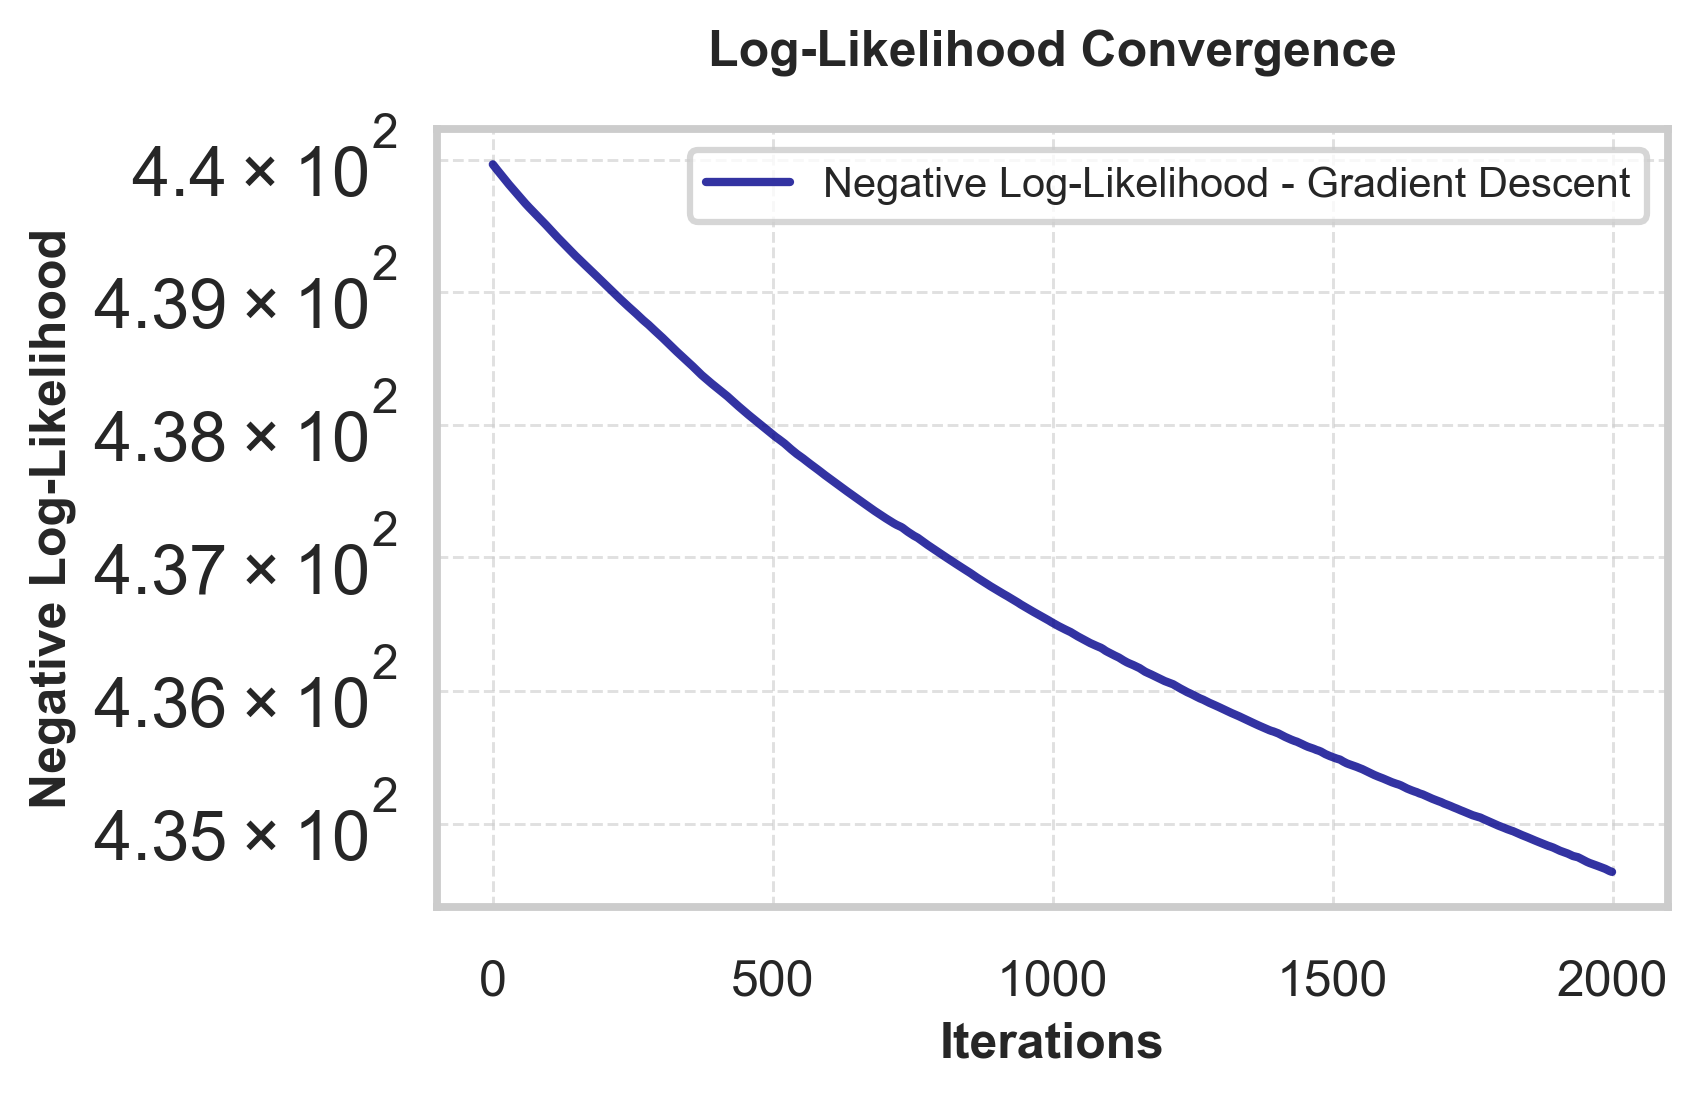

2025-03-25 19:15:14,274 - INFO - Removed 0/1 MLE estimates due to unphysical values (N or r < 0).


In [8]:
# Initial run to show training through gradient descent
mle_results_1 = Antikythera_Isotropic_Basic_Filter.max_likelihood_est(sampling_type = 'Adam', num_samples=1, num_iterations=2500, learning_rate=1, batch_size=50, key=32, derivative='analytic', plot_history=True, summary_table = None, save_path = None)

In [9]:
# Full optimisation using 100 initialisations from prior
if rerun_comp_expensive_analysis:
    mle_results_full = Antikythera_Isotropic_Basic_Filter.max_likelihood_est(sampling_type = 'Adam', num_samples=100, num_iterations=1000, learning_rate=0.1, batch_size=50, key=1, derivative='analytic', plot_history=False, summary_table = 5, save_path = 'stored_results/Istropic_Basic_MLE_Results.pkl')
# if not run, load back data
else:
    mle_results_full = pd.read_pickle('stored_results/Istropic_Basic_MLE_Results.pkl')

Optimizing MLE using Adam::   0%|          | 0/100 [00:00<?, ?it/s]

2025-03-25 19:21:33,098 - INFO - Removed 0/100 MLE estimates due to unphysical values (N or r < 0).


,N,r,x0,y0,alpha,sigma,Log-Likelihood
0,352.3938171496296,75.76698008486471,"[78.71,76.11,78.65,92.17,66.14,86.46]","[134.77,135.7 ,134.2 ,138.23,126.89,135.58]","[-2.55,-2.5 ,-2.53,-2.71,-2.33,-2.63]",0.86,[-129.92744073042505]
1,369.9934664318743,77.22574877794615,"[83.71,75.28,84.47,94.37,76.7 ,72.05]","[131.26,139.5 ,135.01,138.32,134.26,130.96]","[-2.62,-2.45,-2.56,-2.68,-2.44,-2.36]",0.83,[-172.74259345052553]
2,366.95424149710163,81.14524499261096,"[83.18,72.65,73.76,90.79,82.18,74.27]","[137.97,143.23,140.24,139.62,138.92,135.59]","[-2.55,-2.4 ,-2.43,-2.65,-2.53,-2.43]",0.98,[-186.55236578506646]
3,349.7243940210365,79.94372762516834,"[76.37,76.14,79.77,65.52,82.58,68.11]","[142.24,137.68,138.34,132.86,138.84,131.94]","[-2.46,-2.5 ,-2.55,-2.38,-2.6 ,-2.4 ]",0.98,[-192.98372453436494]
4,366.9098178737809,85.75382691983575,"[81.72,93.64,86.86,81.95,58.26,74.57]","[145.22,136.68,144.01,144.66,131.89,141.67]","[-2.48,-2.66,-2.58,-2.55,-2.23,-2.46]",0.89,[-211.47865172171933]


2025-03-25 19:21:33,216 - INFO - MLE Run results saved to stored_results/Istropic_Basic_MLE_Results.pkl


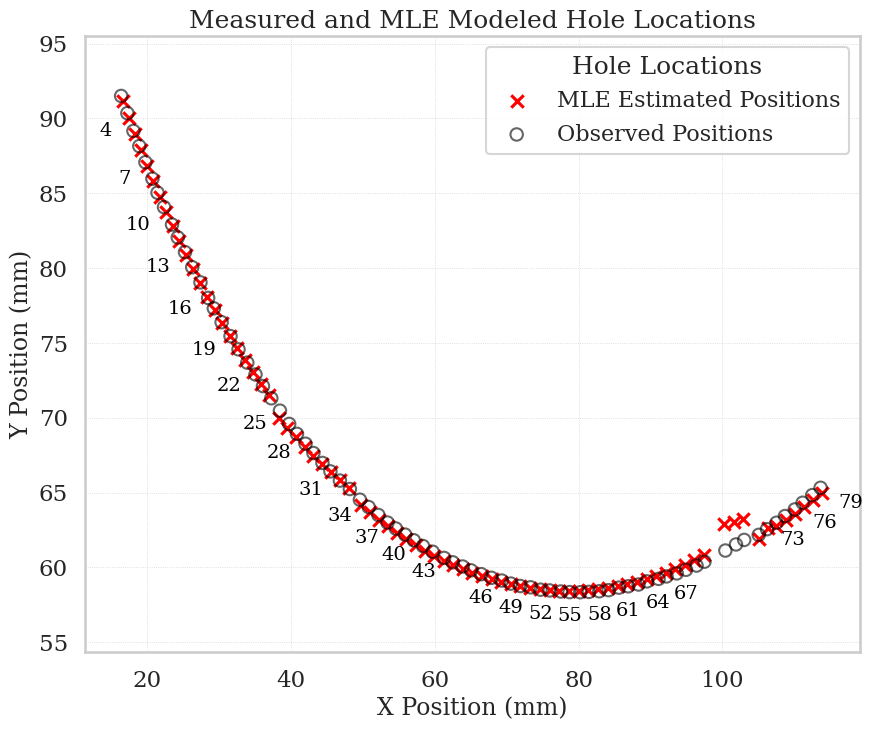

In [3]:
mle_results_full = pd.read_pickle('stored_results/Istropic_Basic_MLE_Results.pkl')
Antikythera_Isotropic_Basic_Filter.mle_analysis(mle_results_full)

## Maximum Likelihood Estimate - Results from `Scipy.optimise` BFGS

In [23]:
# Full optimisation using 100 initialisations from prior
if rerun_comp_expensive_analysis:
    mle_results_full = Antikythera_Isotropic_Basic_Filter.max_likelihood_est(sampling_type = 'BFGS', num_samples=20, derivative='analytic', plot_history=False, summary_table = 5, save_path = 'stored_results/Isotropic_Basic_MLE_Scipy_Results.pkl')
    mle_results_full_scipy = pd.read_pickle('stored_results/Isotropic_Basic_MLE_Scipy_Results.pkl')
# if not run, load back data
else:
    mle_results_full_scipy = pd.read_pickle('stored_results/Isotropic_Basic_MLE_Scipy_Results.pkl')

Optimizing MLE using BFGS::   0%|          | 0/20 [00:00<?, ?it/s]

2025-03-25 19:52:00,117 - INFO - Removed 0/20 MLE estimates due to unphysical values (N or r < 0).


,N,r,x0,y0,alpha,sigma,Log-Likelihood
0,364.838728,79.447469,"[80.96,79.37,80.02,63.48,79.78,81.96]","[137.79,138.38,137.84,131.11,137.52,138.17]","[-2.53,-2.51,-2.52,-2.29,-2.51,-2.54]",0.10,139.998866
1,360.078379,78.353667,"[80.5 ,79.03,80. ,78.31,87.08,89.97]","[136.71,137.36,136.72,136.2 ,138.41,139.78]","[-2.54,-2.52,-2.53,-2.51,-2.61,-2.66]",0.10,134.370992
2,359.753701,78.251431,"[80.88,77.24,79.98,65.08,68.06,87.52]","[136.19,138.09,136.62,130.54,131.07,138.86]","[-2.55,-2.49,-2.53,-2.32,-2.35,-2.62]",0.11,121.639406
3,370.000000,80.956877,"[82.04,78.17,80.42,79.3 ,85.16,79.8 ]","[138.85,140.69,139.33,139.25,140.7 ,138.88]","[-2.53,-2.48,-2.51,-2.5 ,-2.56,-2.5 ]",0.11,119.759949
4,357.086874,77.931085,"[80.14,76.43,79.83,66.74,92.64,77.61]","[136.37,138.15,136.31,131.1 ,139.58,134.81]","[-2.54,-2.49,-2.53,-2.35,-2.7 ,-2.5 ]",0.13,106.748404


2025-03-25 19:52:00,153 - INFO - MLE Run results saved to stored_results/Isotropic_Basic_MLE_Scipy_Results.pkl


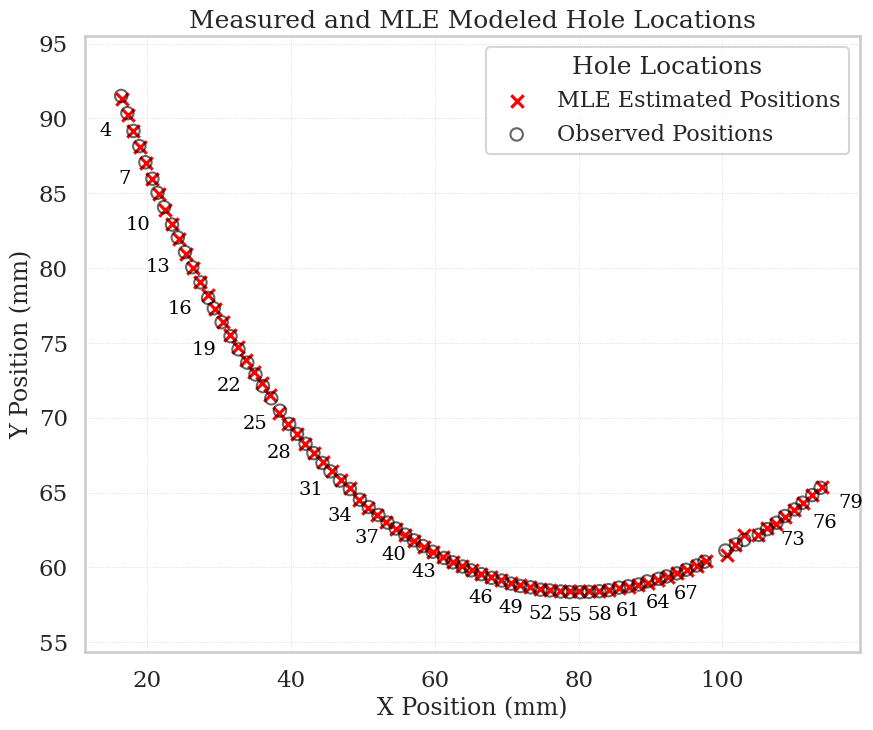

In [4]:
mle_results_full_scipy = pd.read_pickle('stored_results/Isotropic_Basic_MLE_Scipy_Results.pkl')
Antikythera_Isotropic_Basic_Filter.mle_analysis(mle_results_full_scipy)

# Posterior Analysis 

- [Numpyro Model Docs](https://coursework-s2.readthedocs.io/en/latest/Calender_Analysis/index.html#calender_analysis.analysis.Calender_Analysis.numpryo_model)
- [NUTS Docs](https://coursework-s2.readthedocs.io/en/latest/Calender_Analysis/index.html#calender_analysis.analysis.Calender_Analysis.run_hmc_nuts)

### Hamiltonian Monte Carlo (No U-Turn) Sampling 

#### **Burn-in Adaptation: NUTS vs. Ordinary HMC**

Unlike standard HMC, where step size and trajectory length must be manually tuned before sampling begins, NUTS uses the burn-in phase to learn and adjust these hyperparameters automatically.

| Feature                  | Ordinary HMC                          | NUTS (No-U-Turn Sampler) |
|--------------------------|--------------------------------------|--------------------------|
| **Step Size Adjustment** | Fixed, requires manual tuning       | Adapted dynamically via dual averaging |
| **Trajectory Length**    | Fixed number of leapfrog steps, must be pre-set | Automatically determined using U-turn detection |
| **Mass Matrix**          | Typically diagonal, no adaptation   | Adapted dynamically (dense or diagonal) based on posterior correlations |
| **Efficiency**           | Can be inefficient if hyperparameters are poorly chosen | Self-adjusting, more efficient for complex posteriors |

#### **No U Turn Criterion**
- In NUTS the sampler dynamically decides when to stop each trajectory, avoiding U-turns and prevents excessive computation
- Efficiently explores the posterior distribution.


### Burn In Analysis
- Determining optimal burn-in is not only important to ensure that samples have converged to stationary distribution but also allows sample to dynamically adjust to posterior (trajectory length, mass matrix)

#### Short Burn In - 40 Samples

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         N    355.47      4.10    355.34    349.02    362.52    402.69      1.00
  alpha[0]     -2.54      0.00     -2.54     -2.55     -2.54    722.75      1.00
  alpha[1]     -2.54      0.01     -2.54     -2.56     -2.52   1084.54      1.00
  alpha[2]     -2.54      0.01     -2.54     -2.56     -2.52    406.18      1.00
  alpha[3]     -2.56      0.05     -2.56     -2.65     -2.48    601.69      1.00
  alpha[4]     -2.52      0.11     -2.53     -2.71     -2.34     33.65      1.13
  alpha[5]     -2.58      0.02     -2.58     -2.62     -2.54    537.50      1.01
         r     77.39      0.88     77.37     76.03     78.93    402.06      1.00
     sigma      0.09      0.01      0.09      0.09      0.10   2170.54      1.00
     x0[0]     79.72      0.63     79.71     78.72     80.77    414.63      1.00
     x0[1]     79.93      0.76     79.91     78.69     81.20    926.35      1.00
     x0[2]     79.87      0

/Users/jacobtutt/Desktop/MPhil_DIS/S2/Coursework_S2/calender_analysis/analysis.py:1879: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


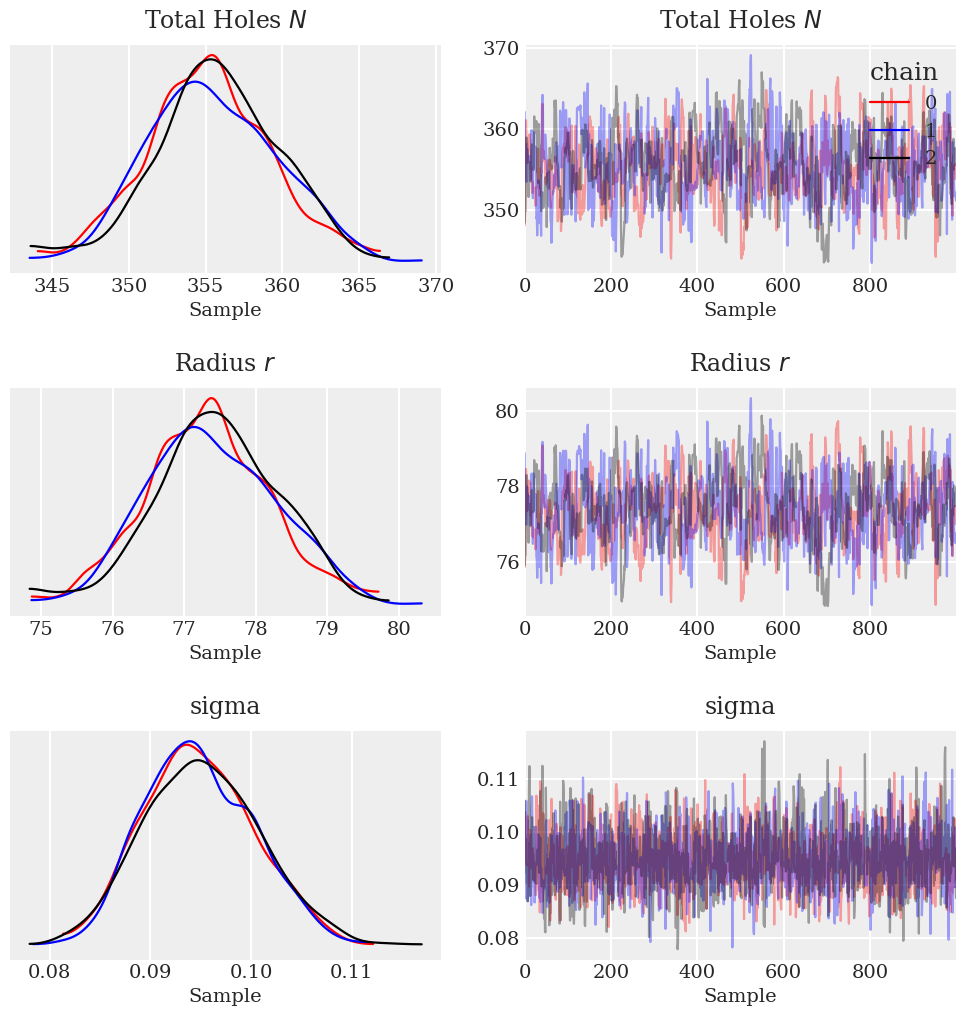

2025-03-25 19:21:47,227 - INFO - Total MCMC Run Time: 12.59 seconds 
 Non Burn-In Run Time: 12.10 seconds


In [11]:
short_burn_in = Antikythera_Isotropic_Basic_Filter.run_hmc_nuts(burnin_period=40, n_samples=1000, n_chains=3, step_size=1, acceptance_prob=0.8, dense_mass=False, summary = True, random_seed=0, save_path=None, traceplot= ['N', 'r', 'sigma'], progress_bar=True)

#### Long Burn In - 600 Samples

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         N    355.82      4.69    355.83    348.65    364.15    393.61      1.00
  alpha[0]     -2.54      0.00     -2.54     -2.55     -2.54    598.99      1.00
  alpha[1]     -2.54      0.01     -2.54     -2.56     -2.52    955.76      1.00
  alpha[2]     -2.54      0.01     -2.54     -2.56     -2.52    403.60      1.00
  alpha[3]     -2.56      0.05     -2.56     -2.64     -2.48   1356.02      1.00
  alpha[4]     -2.55      0.10     -2.55     -2.71     -2.37   1446.33      1.01
  alpha[5]     -2.58      0.02     -2.58     -2.62     -2.54    693.14      1.00
         r     77.46      1.01     77.46     75.83     79.17    392.36      1.00
     sigma      0.10      0.01      0.09      0.09      0.10   2244.60      1.00
     x0[0]     79.77      0.72     79.77     78.57     80.95    409.18      1.00
     x0[1]     79.95      0.79     79.93     78.72     81.30    735.78      1.00
     x0[2]     79.88      0

/Users/jacobtutt/Desktop/MPhil_DIS/S2/Coursework_S2/calender_analysis/analysis.py:1879: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


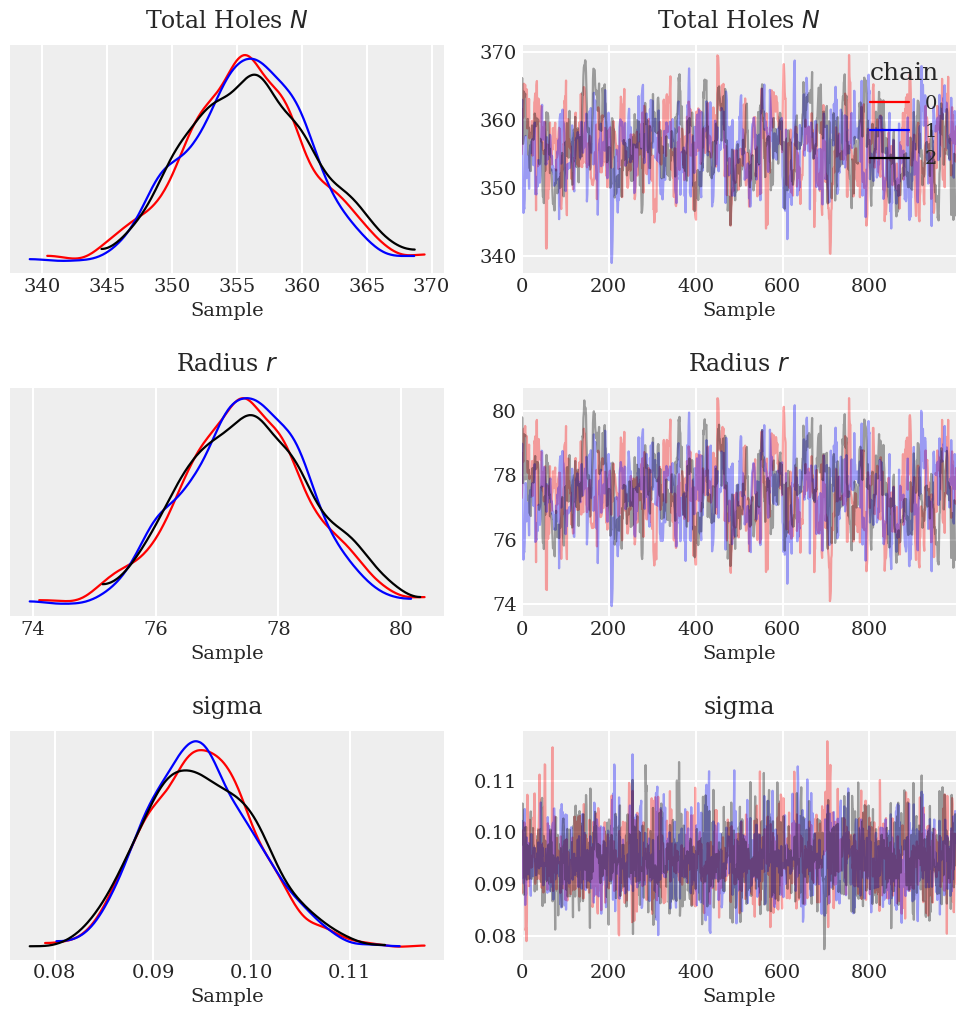

2025-03-25 19:22:06,735 - INFO - Total MCMC Run Time: 19.09 seconds 
 Non Burn-In Run Time: 11.93 seconds


In [12]:
long_burn_in = Antikythera_Isotropic_Basic_Filter.run_hmc_nuts(burnin_period=600, n_samples=1000, n_chains=3, step_size=1, acceptance_prob=0.8, dense_mass=False, summary = True, random_seed=1, save_path=None, traceplot= ['N', 'r', 'sigma'], progress_bar=True)

## **Optimising Initialisation**  


- [NUTS optimisation Docs](https://coursework-s2.readthedocs.io/en/latest/Calender_Analysis/index.html#calender_analysis.analysis.Calender_Analysis.run_hmc_optimisation)



Although optimisation of initial parameters is less important than in traditional Hamiltonian Monte Carlo, as the **NUTS algorithm** dynamically adjusts hyperparameters during the **burn-in phase** and determines trajectory length automatically, it is still performed to **minimise the required burn-in period**. By selecting **good initialisation points**, the adaptation phase can be shortened, leading to **more efficient sampling**.  

### **Metrics Measured**  
- **Autocorrelation Length**: Estimated autocorrelation length.  
- **Number of Effective Samples**: Minimum effective sample size across parameters.  
- **GR Statistic**: Gelman-Rubin diagnostic (values close to 1 indicate convergence).  
- **Time per Iteration**: Average computation time per sample.  

### **Optimisation Criterion**  
- **Time Per Effective Sample**: Measures overall computational efficiency. Lower values indicate faster convergence and better sampling efficiency.  


In [13]:
if rerun_comp_expensive_analysis:
    step_size_range = [0.05, 0.1, 0.5, 1, 5]
    acceptance_prob_range = [0.65, 0.75, 0.85, 0.90]
    dense_mass_options = [False, True]
    nuts_optimal_params = Antikythera_Isotropic_Basic_Filter.run_hmc_optimisation(step_size_range, acceptance_prob_range, dense_mass_options, burnin_period=1000, n_samples=2000, n_chains=4, random_seed=0, save_path='stored_results/Istropic_Basic_HMC_Opt_Results.csv', no_table_results=5)

2025-03-25 19:22:06,805 - INFO - Running MCMC 1/40 | step_size=0.05, accept_prob=0.65, dense_mass=False
2025-03-25 19:22:33,837 - INFO - Total MCMC Run Time: 27.00 seconds 
 Non Burn-In Run Time: 18.00 seconds
2025-03-25 19:22:33,988 - INFO - Running MCMC 2/40 | step_size=0.05, accept_prob=0.65, dense_mass=True
2025-03-25 19:22:42,865 - INFO - Total MCMC Run Time: 8.88 seconds 
 Non Burn-In Run Time: 5.92 seconds
2025-03-25 19:22:43,005 - INFO - Running MCMC 3/40 | step_size=0.05, accept_prob=0.75, dense_mass=False
2025-03-25 19:23:14,335 - INFO - Total MCMC Run Time: 31.33 seconds 
 Non Burn-In Run Time: 20.89 seconds
2025-03-25 19:23:14,488 - INFO - Running MCMC 4/40 | step_size=0.05, accept_prob=0.75, dense_mass=True
2025-03-25 19:23:22,077 - INFO - Total MCMC Run Time: 7.59 seconds 
 Non Burn-In Run Time: 5.06 seconds
2025-03-25 19:23:22,245 - INFO - Running MCMC 5/40 | step_size=0.05, accept_prob=0.85, dense_mass=False
2025-03-25 19:23:58,399 - INFO - Total MCMC Run Time: 36.15 se

## **Run Optimised NUTS**  

Once the **optimal hyperparameters** have been determined, they are used to generate posterior samples for analysis. This ensures that **sampling is as efficient as possible**, reducing the computational cost while maintaining statistical accuracy.  

Instead of running a fixed number of samples, this method **automatically determines** how many total samples need to be generated to achieve the desired number of **independent** (effectively uncorrelated) samples.  

### **Sampling Process**  
1. **Determine total samples needed per chain**  
   - Uses the estimated **autocorrelation length** to compute the necessary number of raw samples.  
   - Ensures that after thinning, the final dataset contains the required number of **independent** samples.  

2. **Run MCMC with optimised hyperparameters**  
   - Uses multiple **parallel chains** to improve convergence diagnostics.  
   - Computes the **Gelman-Rubin statistic (R-hat)** to verify sampling quality.  

3. **Thin the samples**  
   - Selects every `autocorrelation length` sample to ensure the remaining set is effectively independent.  

4. **Save and return results**  
    - **Returns two datasets**:  
    1. **Full posterior samples** (for visualization and diagnostics).  
    2. **Thinned posterior samples** (for statistical analysis, ensuring minimal correlation).  

In [7]:
nuts_optimal_params = pd.read_csv('stored_results/Istropic_Basic_HMC_Opt_Results.csv')
if rerun_comp_expensive_analysis:
    posterior_data, thinned_posterior = Antikythera_Isotropic_Basic_Filter.run_hmc_optimised(nuts_optimal_params, burnin_period=2000, n_samples=12000, n_chains =  4, random_seed=0, save_path = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', traceplot=None)

2025-04-03 13:45:39,724 - INFO - Running MCMC with Optimised Hyperparameters: step_size=0.5, accept_prob=0.75, dense_mass=True
Due to Autocorrelation Length: 3, the number of effective samples is reduced.
Total samples required to achieve 12000 effective samples: 36000
This is run on 4 parrallel chains each running 9000 samples.


  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

2025-04-03 13:46:30,970 - INFO -  MCMC samples saved to stored_results/Isotropic_Basic_Opt_NUTS.nc
2025-04-03 13:46:30,972 - INFO - Total MCMC Run Time: 42.55 seconds 
 Non Burn-In Run Time: 34.82 seconds
2025-04-03 13:46:32,004 - INFO -  Over 4 chains, 36000 were run, 
Achieved Gelman-Rubin Statistic: 1.0048, 
Achieved Effective Samples: 8043, 
True Auto-correlation Length: 5
2025-04-03 13:46:32,007 - INFO - Total samples remaining after thinning: 7200
2025-04-03 13:46:40,845 - INFO - Full MCMC samples saved to stored_results/Isotropic_Basic_Opt_NUTS.nc
 Thinned MCMC samples saved to stored_results/Isotropic_Basic_Opt_NUTS_thinned.nc


## **Analyse NUTS Sampler**

- [HMC Analysis Docs](https://coursework-s2.readthedocs.io/en/latest/Calender_Analysis/index.html#calender_analysis.analysis.Calender_Analysis.thinned_hcm_analysis)
- [Credible Interval Docs](https://coursework-s2.readthedocs.io/en/latest/Calender_Analysis/index.html#calender_analysis.analysis.Calender_Analysis.plot_credible_intervals)

2025-04-03 14:12:38,889 - INFO - Loaded full and thinned posterior data stored_results/Isotropic_Basic_Opt_NUTS.nc.
2025-04-03 14:12:39,112 - INFO - NOTE: When comparing the results to the paper, the section indexes are not comparable, but there order is


,median,68%,90%,95%,99%
parameter,,,,,
N,355.308000,+4.1980 − 4.1630,+7.0380 − 6.8230,+8.3230 − 8.1140,+9.9920 − 10.9030
alpha[0],-145.703167,+0.1719 − 0.1719,+0.2865 − 0.2865,+0.3438 − 0.4011,+0.5157 − 0.4584
alpha[1],-145.645872,+0.5730 − 0.6303,+0.9740 − 1.0313,+1.1459 − 1.2032,+1.5470 − 1.6616
alpha[2],-145.531280,+0.5730 − 0.6303,+0.9740 − 1.0313,+1.1459 − 1.2032,+1.3751 − 1.6043
alpha[3],-146.791787,+2.9221 − 2.7502,+4.8701 − 4.6410,+5.7296 − 5.5004,+7.5057 − 7.1047
alpha[4],-146.619900,+5.0420 − 5.7296,+8.4225 − 9.2819,+9.7976 − 10.5424,+10.5424 − 12.8343
alpha[5],-147.765815,+1.3178 − 1.3751,+2.1199 − 2.2345,+2.5783 − 2.6929,+3.3805 − 3.4377
r,77.353000,+0.9120 − 0.9010,+1.5200 − 1.4840,+1.7960 − 1.7360,+2.1710 − 2.3350
sigma,0.095000,+0.0060 − 0.0050,+0.0110 − 0.0090,+0.0130 − 0.0100,+0.0170 − 0.0130


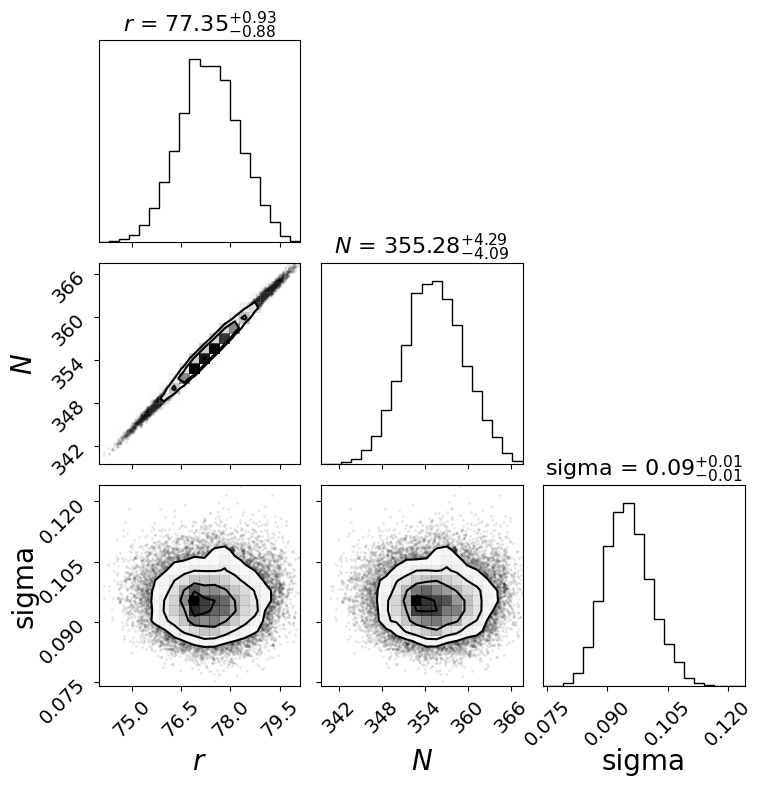

In [3]:
Antikythera_Isotropic_Basic_Filter.thinned_hcm_analysis(posterior_data = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', summary_table=True, corner_plot=["r", "N", "sigma"])

2025-03-25 19:36:45,538 - INFO - Loaded full and thinned posterior data stored_results/Isotropic_Basic_Opt_NUTS.nc.


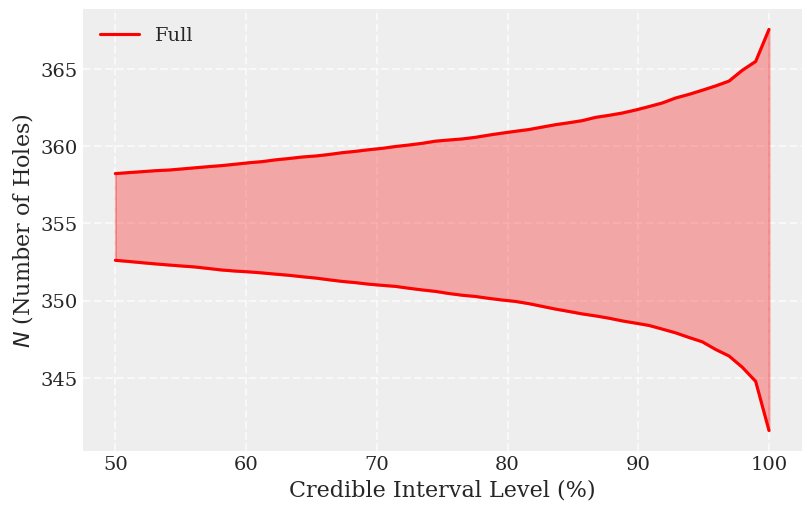

In [16]:
Antikythera_Isotropic_Basic_Filter.plot_credible_intervals(posterior_data = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', param="N", percentiles_range=(50, 100))

2025-03-25 19:36:45,853 - INFO - Loaded full and thinned posterior data stored_results/Isotropic_Basic_Opt_NUTS.nc.


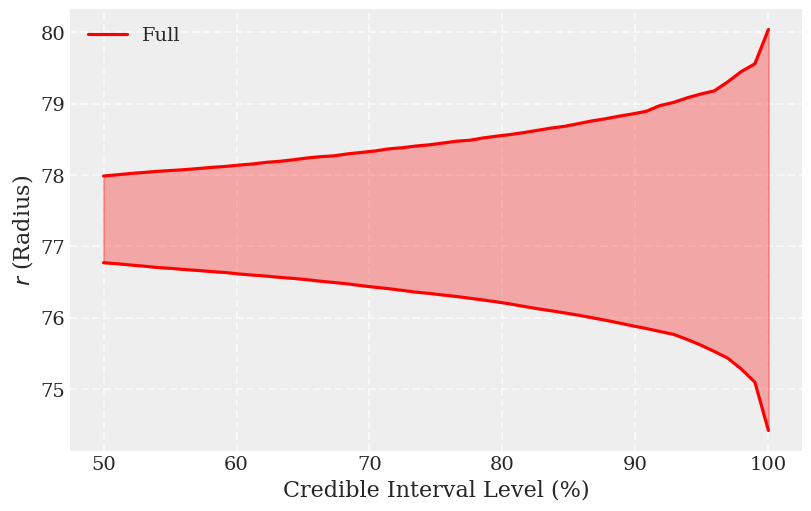

In [17]:
Antikythera_Isotropic_Basic_Filter.plot_credible_intervals(posterior_data = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', param="r", percentiles_range=(50, 100))

2025-03-25 19:36:46,071 - INFO - Loaded full and thinned posterior data stored_results/Isotropic_Basic_Opt_NUTS.nc.


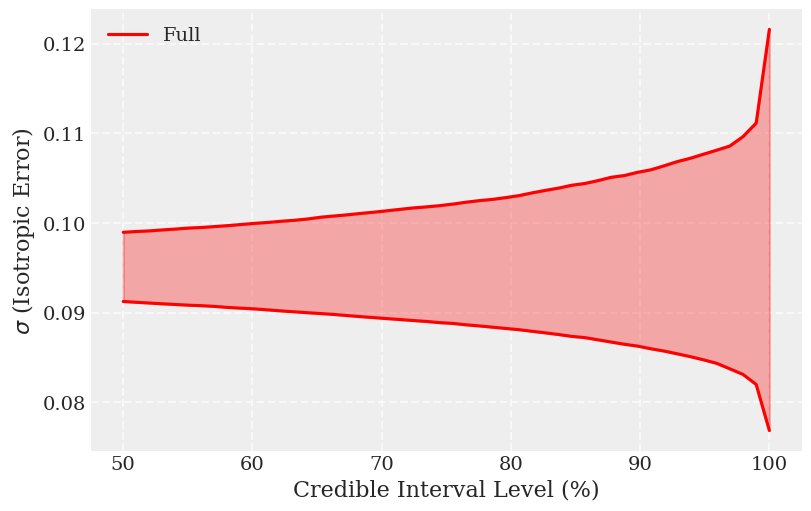

In [18]:
Antikythera_Isotropic_Basic_Filter.plot_credible_intervals(posterior_data = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', param="sigma", percentiles_range=(50, 100))

2025-04-03 18:31:19,573 - INFO - Loaded thinned posterior data from NetCDF file.
2025-04-03 18:31:19,573 - INFO - Loaded posterior data from NetCDF file.
2025-04-03 18:31:29,684 - WARNING - Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
2025-04-03 18:31:29,786 - WARNING - Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


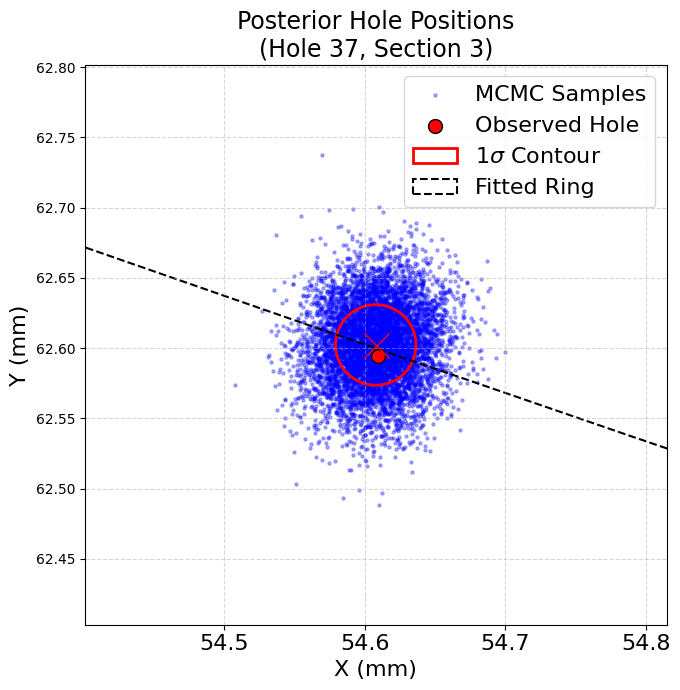

In [3]:
Hole_loc = Antikythera_Isotropic_Basic_Filter.plot_posterior_holes_2(posterior_data = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', hole_no=37, section_no=3)

2025-04-03 18:36:54,087 - INFO - Loaded thinned posterior data from NetCDF file.
2025-04-03 18:36:54,087 - INFO - Loaded posterior data from NetCDF file.
2025-04-03 18:37:03,347 - WARNING - Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
2025-04-03 18:37:03,435 - WARNING - Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


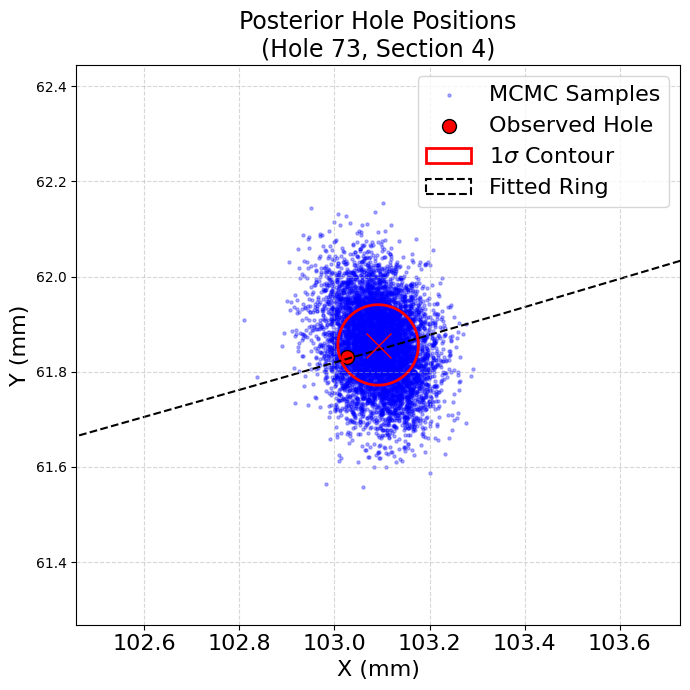

In [3]:
Hole_loc = Antikythera_Isotropic_Basic_Filter.plot_posterior_holes_2(posterior_data = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', hole_no=73, section_no=4 )

2025-04-03 18:31:38,493 - INFO - Loaded thinned posterior data from NetCDF file.
2025-04-03 18:31:38,493 - INFO - Loaded posterior data from NetCDF file.
2025-04-03 18:31:46,563 - WARNING - Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
2025-04-03 18:31:46,586 - WARNING - Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


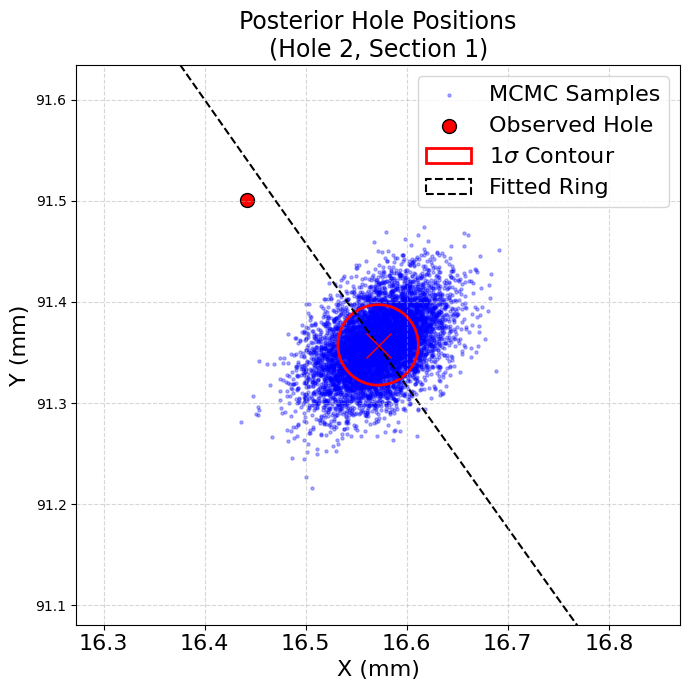

In [5]:
Hole_loc = Antikythera_Isotropic_Basic_Filter.plot_posterior_holes_2(posterior_data = 'stored_results/Isotropic_Basic_Opt_NUTS.nc', hole_no=2, section_no=1)